# BVCT - TTI Car2X Praktikum
**************************************************
Author: 
Date: 
*******************

## Evaluation of Link Budget / Theoretical Basics

$P_e = P_S +G_S - L_S -L_O - L_1 + G_E -L_E$

* measurable units:  $P_S, G_S, L_S, G_E, L_E $
* model assumptions: $L_O, L_1 $  

Estimation of $\lambda$:

$\lambda= \frac{c}{f}, c = 3*10⁸$  

Estimation of $L_O$:

$L_O = 20*\lg{\frac{4*\pi*d}{\lambda}}$

**Conventions**

* dB = Dezibel  
* dBm = $20*\lg(\frac{P}{mW})$  according to mW  
* dBi ~ according to an isotrop monopol 



In [ ]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt



lambda: 0.0508474576271


Text(0.5,1,'Theoretical Link Budget')

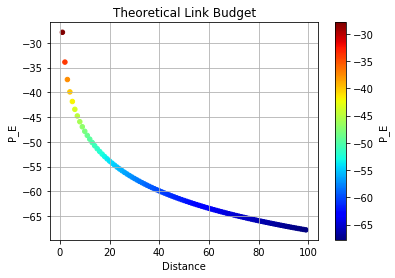

In [145]:
## use python to generate csv 
# todo :define Parameters!
L_E = 2
G_E = 5
L_1 = 0
L_S = 2
G_S = 5 
P_S = 20
# todo: create distance array in range of [1..50]m 
# regard that log of 0 is not defined
distance = np.arange(1,100,1)
# todo:define frequence and parameter c, calculate lambda 
freq = 5.9*10**9 
c = 3.0*10**8
l  = c/freq
print('lambda: {}'.format(l))
# calculate L_0 and P_E 
def calc_L_0(x):
    return 20*math.log10(4*np.pi*2*x/l)

def calc_P_E(L_0):
    return P_S+G_S-L_S-L_0-L_1+G_E-L_E

L_0 =list(map(calc_L_0, distance))
P_E =list(map(calc_P_E,L_0))

# create Dataframe 
d1 = {'Distance': distance, 'L_0': L_0, 'P_E':P_E}
theoretical = pd.DataFrame(data=d1)
# todo: plot P_E over distance use 
theoretical.plot.scatter(x='Distance',y ='P_E', c='P_E',cmap='jet',grid='on')
plt.title('Theoretical Link Budget')

In [146]:
# todo: plot P_E over distance use 
# theoretical.plot()


## Evaluations of Measurements
**Reading csv data with pandas (python library) **

In [147]:
import pandas as pd
#todo: enter filename 
filename = "record1.csv" 
pathToData = 'data/'
fullPathToFile = pathToData+filename
data = pd.read_csv(fullPathToFile,sep=';',index_col=False)
data.rename(columns=lambda x: x.strip(), inplace=True) # remove whitespace from data frame
data.head()

timestamp   stationID        lat        lon  speed  heading  rxPower  \
0  1.537782e+09  2952680210  51.034714  13.739668   0.00    286.5      -32   
1  1.537782e+09           0  51.034697  13.739615   0.01    111.9        0   
2  1.537782e+09  2952680210  51.034714  13.739668   0.00    286.5      -32   
3  1.537782e+09           0  51.034697  13.739615   0.01    111.9        0   
4  1.537782e+09  2952680210  51.034714  13.739668   0.00    286.5      -32   

   distanceToEgo  
0         -1.000  
1          0.000  
2         10.531  
3          0.000  
4         10.531

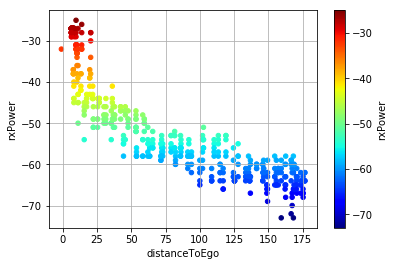

In [148]:
## Plot and filter 
#todo:  disregard id with 0 entries
data1 = data[data.stationID !=0]
# uncomment lines below if you like to use a colored plot 
# plot x='distanceToEgo' over  y='rxPower' 
data1.plot.scatter(x='distanceToEgo', y='rxPower',grid='on' ,c ='rxPower',cmap = 'jet')



## Calc Distance 
Calculate the distance between sender and receiver. Use the GPS Information provided by the Car2X CAM message <br></br>

**todo: Find a appropiate way to calc distance between GPS positions
e.g. haversine or easier implementations** 

Reference Station Pos Lat 51.0347028455 Lon : 13.7396213754
/home/ecke/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


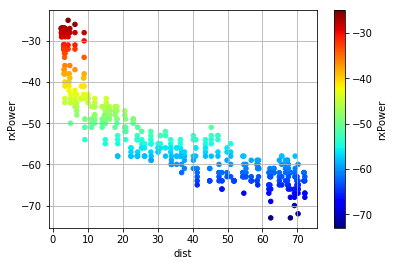

In [149]:
# todo :

# solution:
# reference station - asume fixed position
lonRef = data[data.stationID ==0].lon.mean()
latRef = data[data.stationID ==0].lat.mean()
print('Reference Station Pos Lat {} Lon : {}'.format(latRef,lonRef))

# get values from frame as array
lon = data1['lon'].values
lat = data1['lat'].values
diffLon = lonRef-lon
sumLat = lat+latRef
diffLat = latRef-lat

dxFun = lambda x,y: x*4000*math.cos(y*math.pi/360)/36
dyFun = lambda y:y*4000/36
dx = np.asarray(map(dxFun,diffLon,sumLat))
dy = np.asarray(map(dyFun,diffLat))
dist = np.sqrt(dx**2+dy**2)*1000

data1['dist']  =dist # add to dataframe 
# plot distance over rx for relevant station id 
data1.plot.scatter(x='dist', y='rxPower',c = 'rxPower',grid='on', cmap='jet')



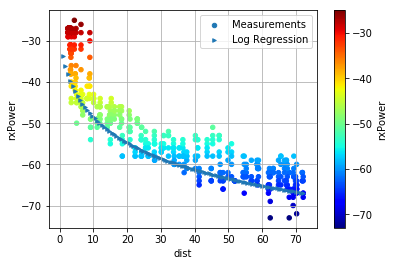

In [150]:
## Todo: Easy implementation using numpy and polyval + poly
rx_max = max(abs(data1['rxPower']))
dist_max = max(abs(data1.dist))
# use query as an other ellegant way to filter pandas dataframe
fdata = data1.query('dist >0')
rx = fdata['rxPower'].values
dist = fdata['dist'].values 
A,B = np.polyfit(np.log(dist), rx, 1) # use log expression 
# y ≈ A* log(x) +B
x =  np.linspace(1,dist_max,100)
y =  abs(np.polyval([A,B],x))
y = -np.log(y)*10

# plot regression result 
fig, ax = plt.subplots()
data1.plot.scatter(x='dist', y='rxPower',c = 'rxPower',grid=True, cmap='jet',ax=ax,label='Measurements')
ax.scatter(x =x, y =y , marker='>',s=12, label='Log Regression')
plt.legend()


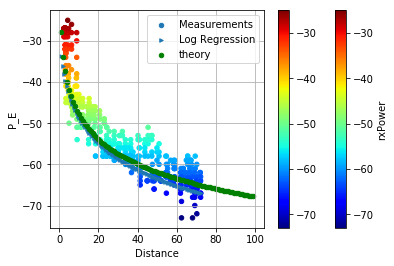

In [156]:
# Compare theoretical and practical results -  plot everything together 
fig, ax = plt.subplots()
data1.plot.scatter(x='dist', y='rxPower',c = 'rxPower',grid=True, cmap='jet',ax=ax,label='Measurements')
ax.scatter(x =x, y =y , marker='>',s=12, label='Log Regression')
theoretical.plot.scatter(x='Distance',y ='P_E', c='g',grid='on',label='theory',ax=ax)
plt.legend()


## Error Analysis